# Tabula Sapiens

In [16]:
import os
import sys
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import numpy
import pickle
from scipy.sparse import issparse, csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
EMBPATH  = "/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens"

In [4]:
def getFiles(category=None, model=None):
    h5ad_files = [] # list of all files
    targets    = [] # list of target
    for root, dirs, files in os.walk(DATAPATH):
        for file in files:
            if file.endswith('.h5ad'):
                h5ad_files.append(os.path.join(root, file))
    for root, dirs, files in os.walk(EMBPATH):
        for file in files:
            if file.endswith('.h5ad'):
                h5ad_files.append(os.path.join(root, file))
    for file in h5ad_files:
        if category is None and model in file:
            targets.append(file)
        elif model is None and category in file:
            targets.append(file)
        elif model == 'raw' and category in file:
            if 'geneformer' not in file and 'scgpt' not in file and 'Tgpt' not in file:
                targets.append(file)
        elif model is not None and category is not None and model in file and category in file:
            targets.append(file)
    return targets

getFiles(category = 'TS_immune', model='raw') #, model='geneformer') #_geneformer.h5ad

['/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_immune.h5ad']

In [5]:
h5ad_files = []
for root, dirs, files in os.walk(DATAPATH):
    for file in files:
        if file.endswith('.h5ad'):
            h5ad_files.append(os.path.join(root, file))

tsCategories = []
for file in h5ad_files:
    tsCategories.append(file.split('.')[0].split('/')[-1])
print(tsCategories)
models = ['raw', 'geneformer', 'Tgpt', 'scgpt']
print(models)

['TS_germ line', 'TS_stromal', 'TS_Large_Intestine', 'TS_Lymph_Node', 'TS_Skin', 'TS_epithelial', 'TS_Spleen', 'TS_Vasculature', 'TS_Kidney', 'TS_Salivary_Gland', 'TS_Thymus', 'TS_Pancreas', 'TS_Fat', 'TS_Bladder', 'TS_endothelial', 'TS_Blood', 'TS_Trachea', 'TS_Bone_Marrow', 'TS_Tongue', 'TS_Lung', 'TabulaSapiens', 'TS_Liver', 'TS_Small_Intestine', 'TS_immune', 'TS_Uterus', 'TS_Eye', 'TS_Mammary', 'TS_Prostate', 'TS_Heart', 'TS_Muscle']
['raw', 'geneformer', 'Tgpt', 'scgpt']


In [6]:
embedding_files = []
for root, dirs, files in os.walk(EMBPATH):
    for file in files:
        if file.endswith('.h5ad'):
            embedding_files.append(os.path.join(root, file))
print(len(embedding_files))

88


## Scree Plots

In [6]:
output_file = '/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens/summaryStats.pkl'
result = {
    'file':[],
    'data':[],
    'model':[],
    'numCells':[],
    'dimension':[],
    'sigmas':[]
}
i = 0
for category in tsCategories:
    print(category)
    for model in models:
        print(model + ' ' + str(i) + '/86')
        file = getFiles(category = category, model=model)
        if len(file) == 0:
            continue
        file = file[0]
        print(file)
        adata = ad.read_h5ad(file)
        result['file'].append(file)
        result['data'].append(category)
        result['model'].append(model)
        result['numCells'].append(adata.X.shape[0])
        result['dimension'].append(adata.X.shape[1])
        X = adata.X
        if issparse(X):
            X = X.toarray()

        sigmas = np.linalg.svd(X, compute_uv=False)
        result['sigmas'].append(sigmas)
        with open(output_file, 'wb') as f:
            pickle.dump(result, f)

        i += 1

TS_germ line
raw 0/86
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_germ line.h5ad
geneformer 1/86
/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens/TS_germ line_geneformer.h5ad
Tgpt 2/86
/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens/TS_germ line_Tgpt.h5ad
scgpt 3/86
/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens/TS_germ line_scgpt.h5ad
TS_stromal
raw 4/86
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_stromal.h5ad



KeyboardInterrupt



In [ ]:
import subprocess

# Define the number of jobs (assuming one job per file)
num_jobs = len(tsCategories) * len(models)

# SLURM parameters
job_name = "scEmbSvd"
partition = "standard"  # Specify your SLURM partition
nodes = 1
tasks_per_node = 1
cpus_per_task  = 20
memory = "180G"      # Adjust as per your memory requirements
account = 'indikar0'
time = "10:00:00"
# Loop over each category and model to submit jobs
job_id = 1
for category in tsCategories:
    for model in ['raw']: # models:
        file = getFiles(category=category, model=model)
        if len(file) == 0:
            continue
        file = file[0]

        # Construct command to run the Python script with arguments
        command = f"python svd_job.py {file} {category} {model}"

        # SLURM job submission command
        sbatch_cmd = f"sbatch --job-name {job_name} " \
                     f"--partition {partition} " \
                     f"--nodes={nodes} " \
                     f"--time={time} "\
                     f"--account={account} " \
                     f"--ntasks-per-node={tasks_per_node} " \
                     f"--cpus-per-task={cpus_per_task} " \
                     f"--mem={memory} " \
                     f"--output=/home/jpic/scFoundationProject/scFoundationModels/notebooks/datasets/logs/%x-%j.log " \
                     f"--wrap=\"{command}\""
        # print(sbatch_cmd)
        # Submit the job using subprocess
        subprocess.run(sbatch_cmd, shell=True)
        print(f"Submitted job {job_id}/{num_jobs}")
        job_id += 1


### Assemble Results and Visualize

In [55]:
# assemble results
OUTPATH = '/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens/results'

def load_results_files(outpath):
    all_results = {
        'file':[],
        'data':[],
        'model':[],
        'numCells':[],
        'dimension':[],
        'sigmas':[]
    }

    # Iterate over all files in the specified directory
    for filename in os.listdir(outpath):
        if filename.endswith('.pkl'):
            filepath = os.path.join(outpath, filename)
            
            # Load the pickle file
            with open(filepath, 'rb') as file:
                result = pickle.load(file)
                if result['sigmas'] is None:
                    continue
                result['sigmas'] = result['sigmas'] / sum(result['sigmas'])
                result['sigmas'] = result['sigmas'][:20]
                # Use the 'file' entry in the result as the key
                for key in result.keys():
                    all_results[key].append(result[key])

    return all_results

# Call the function and store the results
all_results = load_results_files(OUTPATH)

(99, 6)
(99, 6)
(99, 7)
(1980, 7)


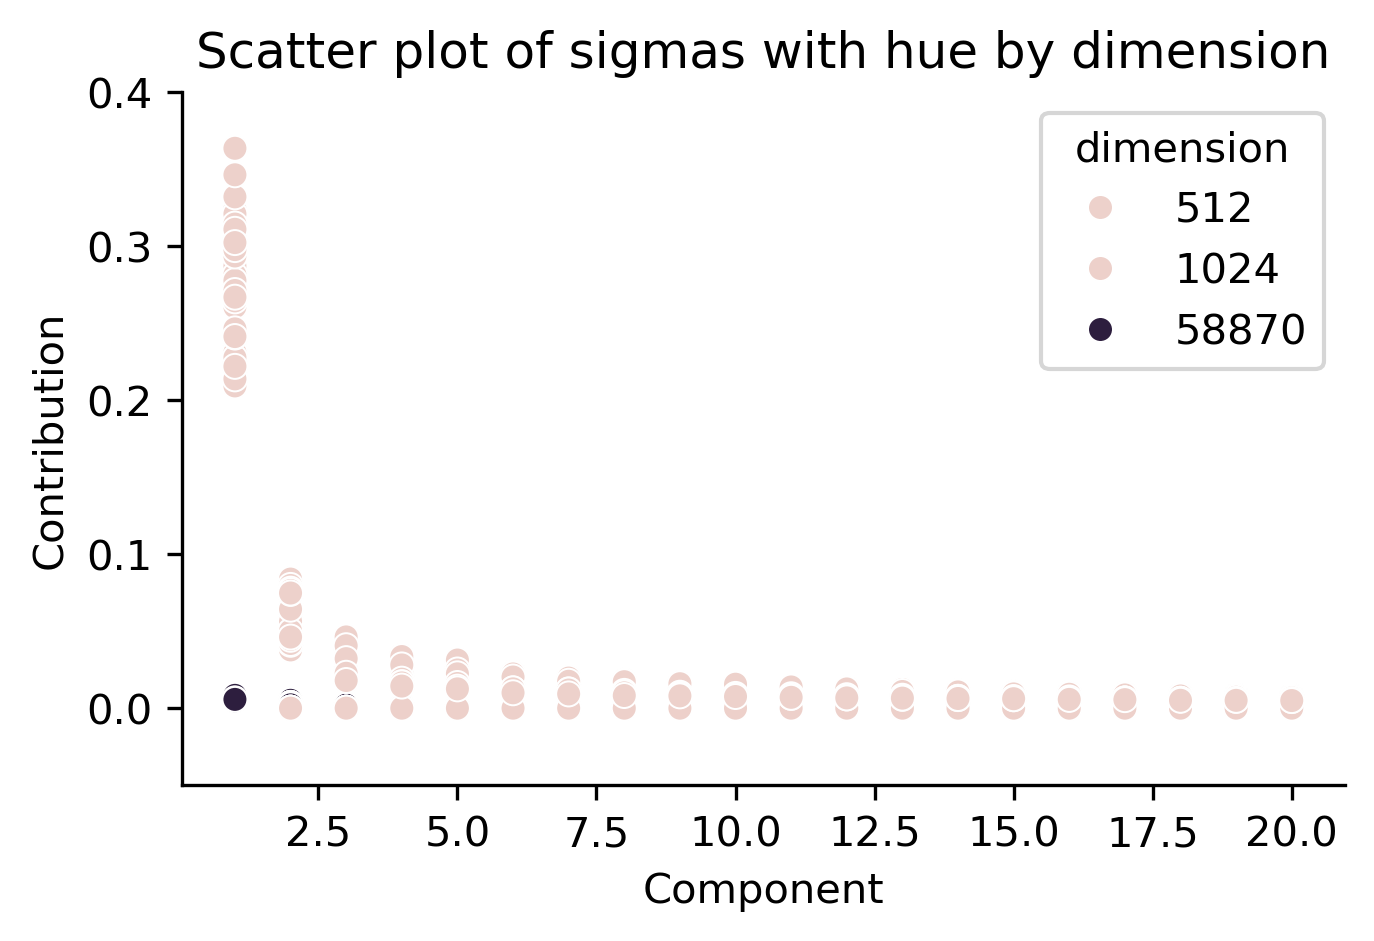

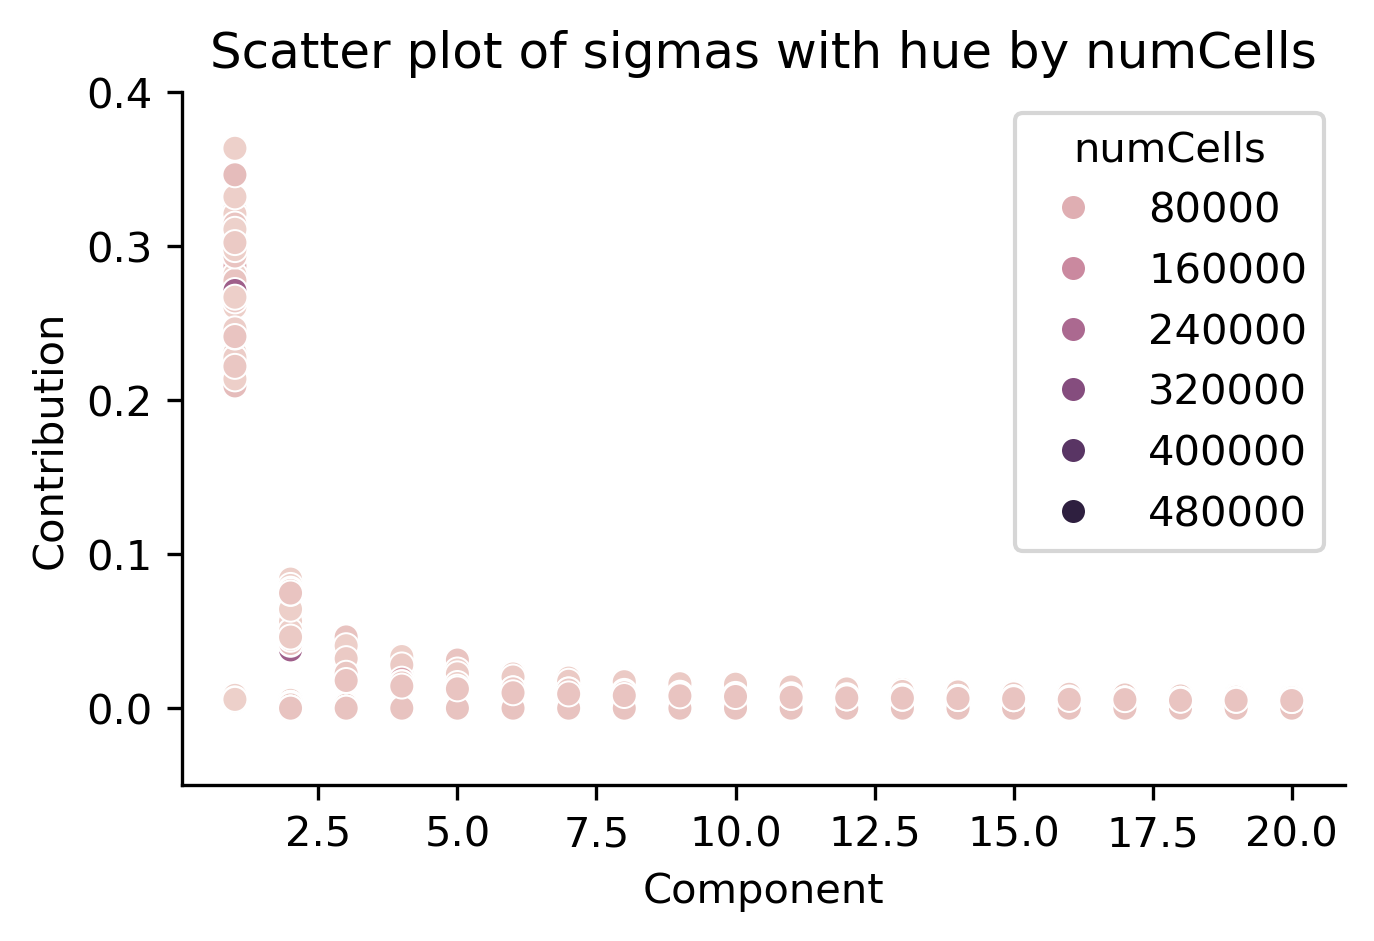

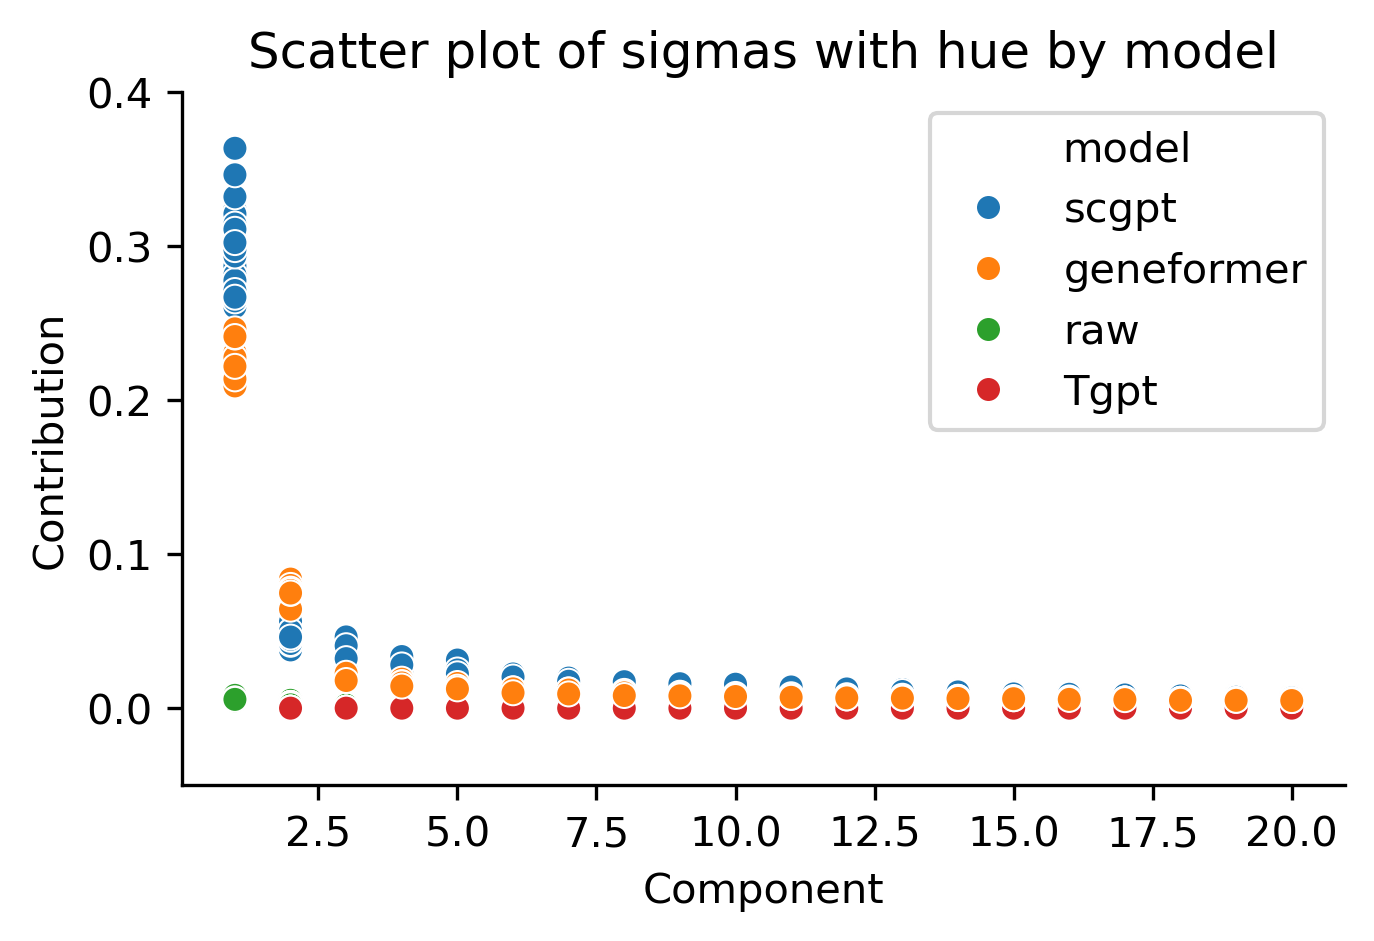

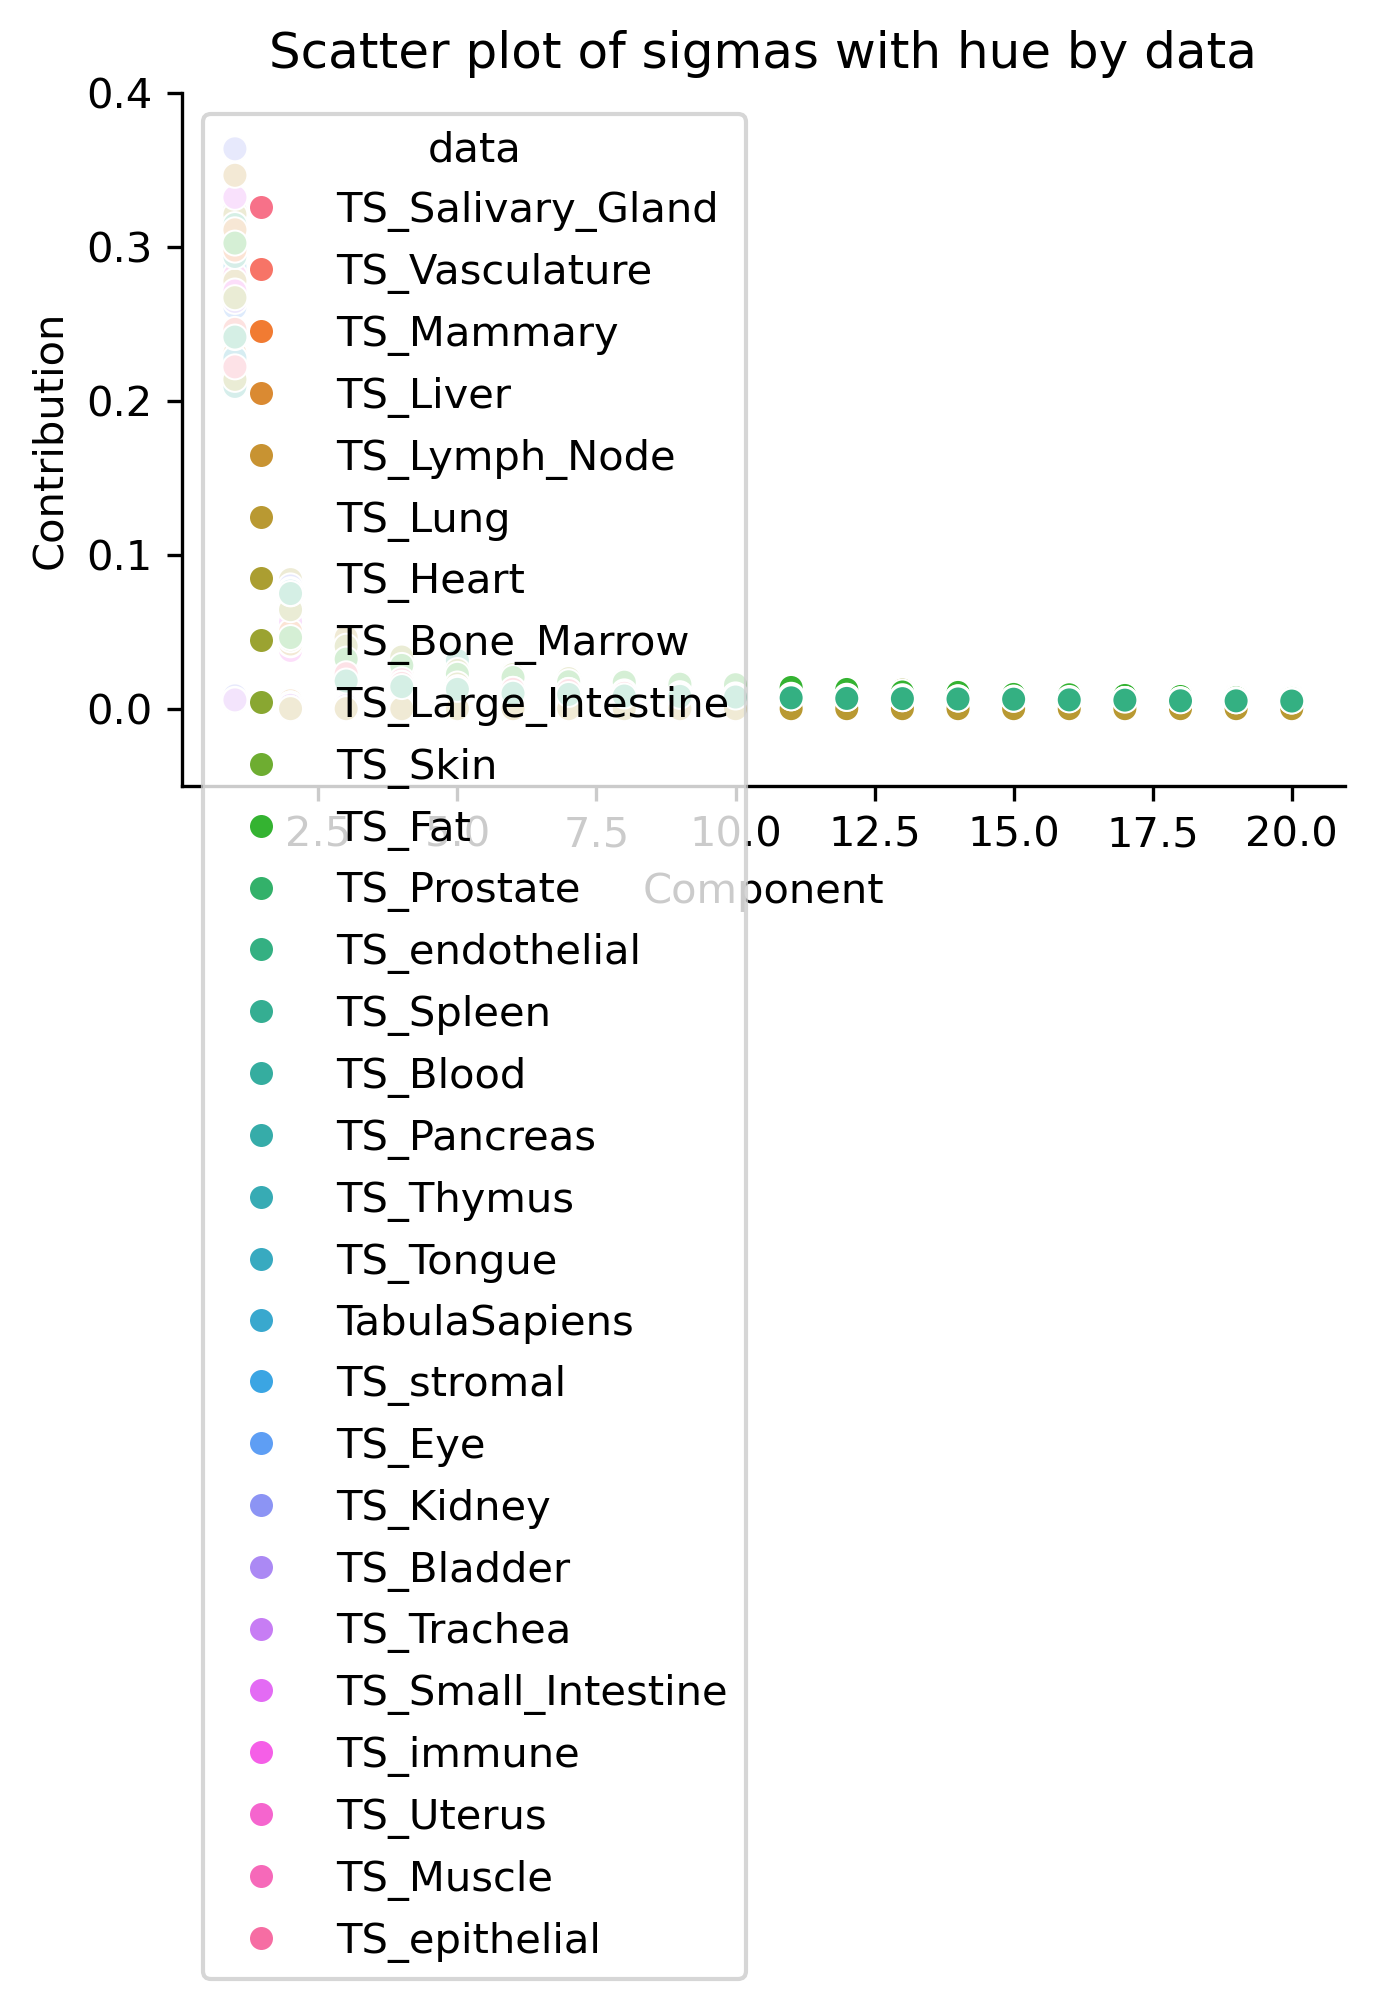

In [60]:
df = pd.DataFrame(all_results)
print(df.shape)
df = df.dropna(subset=['sigmas'])
print(df.shape)
df['xaxis'] = df['sigmas'].apply(lambda sigmas: np.arange(1, len(sigmas) + 1) if sigmas is not None else np.array([]))
df = df.dropna(subset=['xaxis'])
print(df.shape)
df = df.explode(['xaxis', 'sigmas'])
print(df.shape)

def plot_scatter(dataframe, hue):
    plt.figure(figsize=(5, 3), dpi=300)
    sns.scatterplot(data=dataframe, x='xaxis', y='sigmas', hue=hue)
    plt.title(f'Scatter plot of sigmas with hue by {hue}')
    plt.xlabel('Component')
    plt.ylabel('Contribution')
    plt.legend(title=hue)
    plt.ylim([-0.05,0.4])
    sns.despine()
    plt.show()

# Plot for each hue
for hue in ['dimension', 'numCells', 'model', 'data']:
    plot_scatter(df, hue)


In [79]:
df = pd.DataFrame(all_results)
dfLatex = df[['data', 'model', 'numCells', 'dimension', 'sigmas']]
dfLatex['sigmas'] = dfLatex['sigmas'].apply(max)
# Pivot the table
df_refactored = dfLatex.pivot(index='data', columns='model', values=['numCells', 'dimension', 'sigmas'])

# Flatten the column names
df_refactored.columns = ['_'.join(col).strip() for col in df_refactored.columns.values]

# Reset index to make 'data' a regular column
df_refactored = df_refactored.reset_index()

(df_refactored)



/tmp/ipykernel_3724872/3964290489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfLatex['sigmas'] = dfLatex['sigmas'].apply(max)


,data,numCells_Tgpt,numCells_geneformer,numCells_raw,numCells_scgpt,dimension_Tgpt,dimension_geneformer,dimension_raw,dimension_scgpt,sigmas_Tgpt,sigmas_geneformer,sigmas_raw,sigmas_scgpt
0,TS_Bladder,24583.0,24583.0,NaN,24583.0,1024.0,512.0,NaN,512.0,1.0,0.231235,NaN,0.264472
1,TS_Blood,50115.0,50115.0,NaN,50115.0,1024.0,512.0,NaN,512.0,1.0,0.209251,NaN,0.304456
2,TS_Bone_Marrow,12297.0,12297.0,12297.0,12297.0,1024.0,512.0,58870.0,512.0,1.0,0.213824,0.004828,0.266865
3,TS_Eye,10650.0,10650.0,10650.0,10650.0,1024.0,512.0,58870.0,512.0,1.0,0.227085,0.006051,0.260608
4,TS_Fat,20263.0,20263.0,NaN,20263.0,1024.0,512.0,NaN,512.0,1.0,0.243709,NaN,0.302329
5,TS_Heart,11505.0,11505.0,11505.0,11505.0,1024.0,512.0,58870.0,512.0,1.0,0.245533,0.007505,0.320884
6,TS_Kidney,9641.0,9641.0,9641.0,9641.0,1024.0,512.0,58870.0,512.0,1.0,0.245524,0.008322,0.363552
7,TS_Large_Intestine,13680.0,13680.0,13680.0,13680.0,1024.0,512.0,58870.0,512.0,1.0,0.243689,0.004785,0.324011
8,TS_Liver,5007.0,5007.0,5007.0,5007.0,1024.0,512.0,58870.0,512.0,1.0,0.230914,0.008309,0.310947
9,TS_Lung,35682.0,35682.0,NaN,35682.0,1024.0,512.0,NaN,512.0,1.0,0.242351,NaN,0.277693


In [75]:
dfLatex

,data,model,numCells,dimension,sigmas
0,TS_Salivary_Gland,scgpt,27199,512,0.301319
1,TS_Vasculature,scgpt,16037,512,0.281236
2,TS_Mammary,geneformer,11375,512,0.234638
3,TS_Liver,raw,5007,58870,0.008309
4,TS_Lymph_Node,geneformer,53275,512,0.245205
...,...,...,...,...,...
94,TS_Small_Intestine,Tgpt,12467,1024,1.000000
95,TS_Bone_Marrow,geneformer,12297,512,0.213824
96,TS_Lung,Tgpt,35682,1024,1.000000
97,TS_Salivary_Gland,geneformer,27199,512,0.221949


In [77]:
import pandas as pd

# Assuming dfLatex is your original DataFrame
dfLatex = pd.DataFrame({
    'data': ['dataset1', 'dataset1', 'dataset2', 'dataset2', 'dataset3'],
    'model': ['model1', 'model2', 'model1', 'model3', 'model2'],
    'numCells': [100, 150, 200, 250, 300],
    'dimension': [10, 15, 10, 20, 25],
    'sigmas': [0.1, 0.2, 0.3, 0.4, 0.5]
})

# Pivot the table
df_refactored = dfLatex.pivot(index='data', columns='model', values=['numCells', 'dimension', 'sigmas'])

# Flatten the column names
df_refactored.columns = ['_'.join(col).strip() for col in df_refactored.columns.values]

# Reset index to make 'data' a regular column
df_refactored = df_refactored.reset_index()

print(df_refactored)



       data  numCells_model1  numCells_model2  numCells_model3  \
0  dataset1            100.0            150.0              NaN   
1  dataset2            200.0              NaN            250.0   
2  dataset3              NaN            300.0              NaN   

   dimension_model1  dimension_model2  dimension_model3  sigmas_model1  \
0              10.0              15.0               NaN            0.1   
1              10.0               NaN              20.0            0.3   
2               NaN              25.0               NaN            NaN   

   sigmas_model2  sigmas_model3  
0            0.2            NaN  
1            NaN            0.4  
2            0.5            NaN  


## TDA

In [85]:
!pip install scikit-tda

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 34.8 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=32aea5c6c7c16cb3edc1f917c16656fbd9accfdeb85aafe9088b8879a473809c
  Stored in directory: /home/jpic/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [86]:
import ripser
import persim


In [82]:
adata = sc.read_h5ad(h5ad_files[5])

In [83]:
adata.shape

(104148, 58870)

In [87]:
dgm_noisy = ripser.ripser(adata.X, maxdim=2)['dgms']


KeyboardInterrupt: 

# Scratch work for embeddings

In [ ]:
# ts_embedding_1.py
import os
import sys
import scanpy as sc

sys.path.append('../anndata2embedding')
from embed import *

    jobnum = sys.args[1]
    
    sys.path.append('../anndata2embedding')
    from embed import *
    
    DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"
    OUTPUTPATH = '/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens'
    h5ad_files = []
    for root, dirs, files in os.walk(DATAPATH):
        for file in files:
            if file.endswith('.h5ad'):
                h5ad_files.append(os.path.join(root, file))
    
    file = h5ad_files[job_number]
    print(f"Reading file: {file}")
    adata = sc.read_h5ad(file)
    print(f"adata shape: {adata.shape}")
    adata.var['ensembl_id'] = adata.var['ensemblid']
    adata.var['ensembl_id'] = adata.var['ensembl_id'].str.split('.').str[0]

    embedAdGF = embed(adata, 'geneformer',
                      output_directory = OUTPUTPATH,
                      output_file      = os.path.splitext(os.path.basename(file))[0]
                     )
    embedAdGF.write(os.path.splitext(os.path.basename(file))[0] + '_geneformer.h5ad')

    embedAdTgpt = embed(adata, 'tGPT',
                      output_directory = OUTPUTPATH,
                      output_file      = os.path.splitext(os.path.basename(file))[0]
                     )
    embedAdGF.write(os.path.splitext(os.path.basename(file))[0] + '_Tgpt.h5ad')


if __main__():
    main()


In [1]:
import os
import sys
import scanpy as sc

sys.path.append('../anndata2embedding')
from embed import *

general imports
bioinf imports
scgpt wont work
tGPT will work
geneformer will work


In [2]:
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/"

In [27]:
h5ad_files = []
for root, dirs, files in os.walk(DATAPATH):
    for file in files:
        if file.endswith('.h5ad'):
            h5ad_files.append(os.path.join(root, file))
print(len(h5ad_files))
for file in h5ad_files:
    print(file)

30
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_germ line.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_stromal.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Large_Intestine.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Lymph_Node.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Skin.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_epithelial.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Spleen.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Vasculature.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Kidney.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Salivary_Gland.h5ad
/nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_Thymus.h5ad
/nfs/tur

In [8]:
for file in h5ad_files:
    print(f"Reading file: {file}")
    adata = sc.read_h5ad(file)
    print(f"adata shape: {adata.shape}")
    adata.var['ensembl_id'] = adata.var['ensemblid']
    adata.var['ensembl_id'] = adata.var['ensembl_id'].str.split('.').str[0]
    adata.var

Reading file: /nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_germ line.h5ad
adata shape: (11, 58870)
Reading file: /nfs/turbo/umms-indikar/shared/projects/DGC/data/tabula_sapiens/extract/TS_stromal.h5ad



KeyboardInterrupt



In [5]:
adata.var['ensembl_id'] = adata.var['ensemblid']
adata.var['ensembl_id'] = adata.var['ensembl_id'].str.split('.').str[0]
adata.var

,gene_symbol,feature_type,ensemblid,highly_variable,means,dispersions,dispersions_norm,mean,std,ensembl_id
DDX11L1,DDX11L1,Gene Expression,ENSG00000223972.5,False,6.398244e-05,0.835044,-0.573947,0.000039,0.005574,ENSG00000223972
WASH7P,WASH7P,Gene Expression,ENSG00000227232.5,False,2.274395e-03,2.442280,0.533203,0.001080,0.031731,ENSG00000227232
MIR6859-1,MIR6859-1,Gene Expression,ENSG00000278267.1,False,6.175251e-05,1.295335,-0.256874,0.000033,0.005634,ENSG00000278267
MIR1302-2HG,MIR1302-2HG,Gene Expression,ENSG00000243485.5,False,1.372886e-04,2.656352,0.680668,0.000048,0.008041,ENSG00000243485
MIR1302-2,MIR1302-2,Gene Expression,ENSG00000284332.1,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,ENSG00000284332
...,...,...,...,...,...,...,...,...,...,...
MT-ND6,MT-ND6,Gene Expression,ENSG00000198695.2,False,9.634841e-01,2.466404,0.154140,0.590065,0.741395,ENSG00000198695
MT-TE,MT-TE,Gene Expression,ENSG00000210194.1,False,1.600667e-01,1.603787,-0.044396,0.083929,0.301820,ENSG00000210194
MT-CYB,MT-CYB,Gene Expression,ENSG00000198727.2,False,4.367693e+00,4.765751,-0.499747,3.874830,1.104192,ENSG00000198727
MT-TT,MT-TT,Gene Expression,ENSG00000210195.2,False,6.573967e-02,0.624316,-0.719108,0.040580,0.186848,ENSG00000210195


In [20]:
import os
os.path.splitext(os.path.basename(file))[0]

'TS_stromal'

In [21]:
embedAdGF = embed(adata, 'geneformer',
                  output_directory = '/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens',\
                  output_file      = os.path.splitext(os.path.basename(file))[0]
                 )


num_proc must be <= 11. Reducing num_proc to 11 for dataset of size 11.


Map (num_proc=11):   0%|          | 0/11 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11 [00:00<?, ? examples/s]

/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/


  0%|          | 0/2 [00:00<?, ?it/s]

'TS_stromal'

In [23]:
embedAdGF = embed(adata, 'tGPT',
                  output_directory = '/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/tabulaSapiens',\
                  output_file      = os.path.splitext(os.path.basename(file))[0]
                 )


cuda
Tokenizer set
model set
model to device
model eval


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [24]:
embedAdGF

AnnData object with n_obs × n_vars = 11 × 1024
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'n_counts'

In [22]:

embedAdGF.obs

os.path.splitext(os.path.basename(file))[0]


'TS_stromal'